In [ ]:
!pip install imbalanced-learn -q

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


In [ ]:
train_df = pd.read_csv("cs-training.csv")
test_df = pd.read_csv("cs-test.csv")

train_df.head()


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


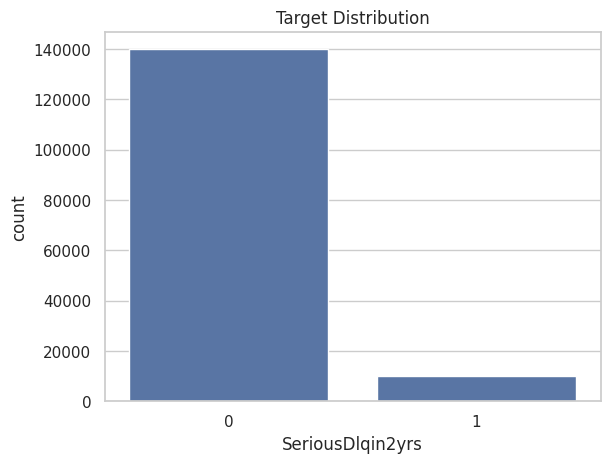

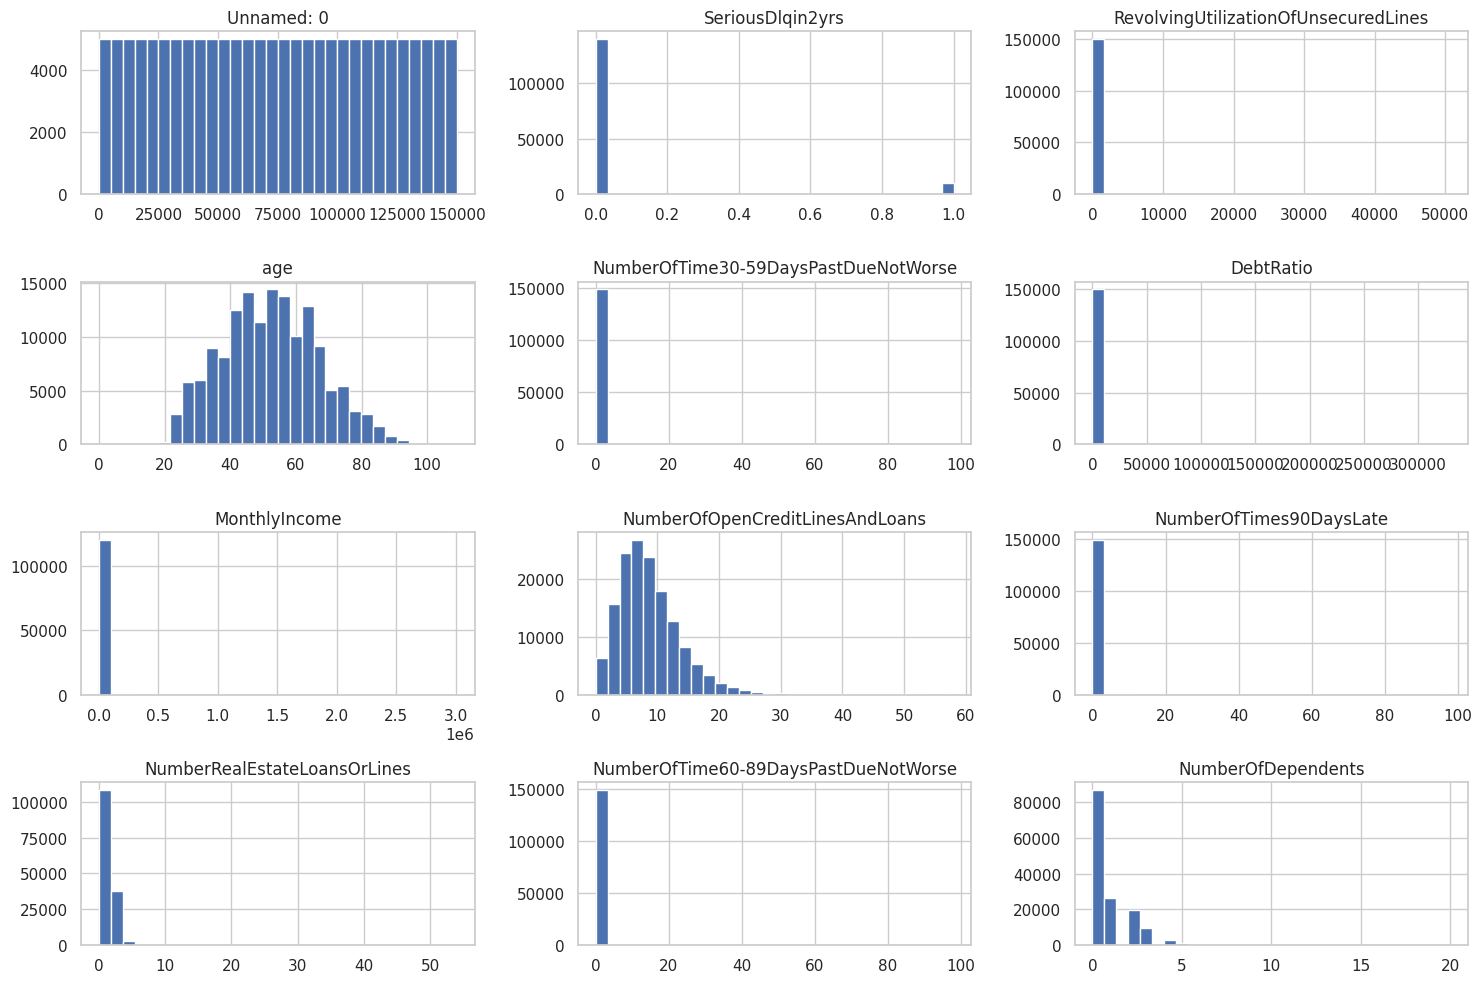

In [ ]:
# Target distribution
plt.figure()
sns.countplot(data=train_df, x='SeriousDlqin2yrs')
plt.title("Target Distribution")
plt.show()

# Check missing values
train_df.isna().mean().sort_values(ascending=False)

# Quick histograms
train_df.hist(bins=30, figsize=(15,10))
plt.tight_layout()
plt.show()


In [ ]:
train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median(), inplace=True)
train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].mode()[0], inplace=True)

test_df['MonthlyIncome'].fillna(test_df['MonthlyIncome'].median(), inplace=True)
test_df['NumberOfDependents'].fillna(test_df['NumberOfDependents'].mode()[0], inplace=True)


In [ ]:
cols_to_clip = [
    'RevolvingUtilizationOfUnsecuredLines',
    'DebtRatio',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate',
    'NumberOfTime60-89DaysPastDueNotWorse'
]

for col in cols_to_clip:
    q99 = train_df[col].quantile(0.99)
    train_df[col] = np.clip(train_df[col], None, q99)
    # IMPORTANT: use same threshold for test set
    test_df[col] = np.clip(test_df[col], None, q99)

train_df['age'] = train_df['age'].clip(lower=21)
test_df['age'] = test_df['age'].clip(lower=21)



In [ ]:
X = train_df.drop(columns=['SeriousDlqin2yrs'])
y = train_df['SeriousDlqin2yrs']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_val.shape


((120000, 11), (30000, 11))

In [ ]:
baseline_pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight=None,  # SMOTE already balances
        n_jobs=-1
    ))
])

baseline_pipeline.fit(X_train, y_train)

y_val_pred = baseline_pipeline.predict(X_val)
y_val_proba = baseline_pipeline.predict_proba(X_val)[:, 1]

baseline_acc = accuracy_score(y_val, y_val_pred)
baseline_auc = roc_auc_score(y_val, y_val_proba)

print("Baseline: Logistic Regression")
print("Accuracy:", baseline_acc)
print("AUC:", baseline_auc)

cm = confusion_matrix(y_val, y_val_pred)
tn, fp, fn, tp = cm.ravel()
print("Confusion matrix:\n", cm)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

print("\nClassification report:")
print(classification_report(y_val, y_val_pred))


Baseline: Logistic Regression
Accuracy: 0.8034333333333333
AUC: 0.8601858632575554
Confusion matrix:
 [[22601  5394]
 [  503  1502]]
TN=22601, FP=5394, FN=503, TP=1502

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.88     27995
           1       0.22      0.75      0.34      2005

    accuracy                           0.80     30000
   macro avg       0.60      0.78      0.61     30000
weighted avg       0.93      0.80      0.85     30000



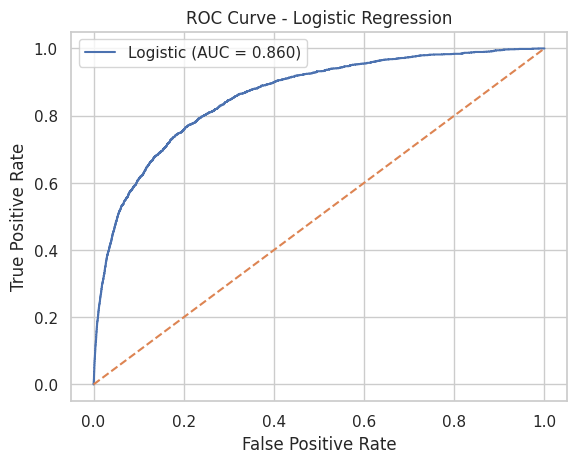

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"Logistic (AUC = {baseline_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


Random Forest
Accuracy: 0.8942
AUC: 0.8306045566562251
Confusion matrix:
 [[25904  2091]
 [ 1083   922]]
TN=25904, FP=2091, FN=1083, TP=922

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94     27995
           1       0.31      0.46      0.37      2005

    accuracy                           0.89     30000
   macro avg       0.63      0.69      0.65     30000
weighted avg       0.92      0.89      0.90     30000



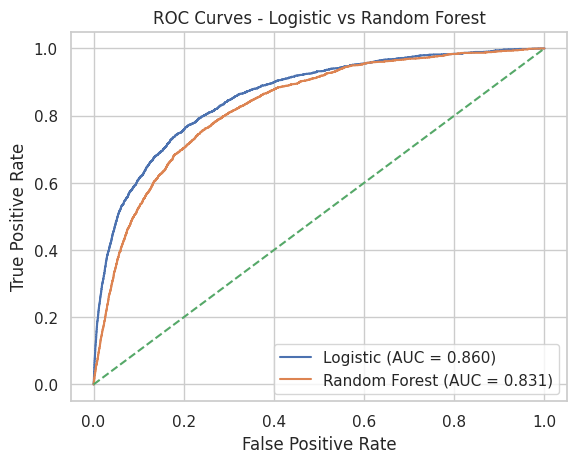

In [ ]:
rf_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42,
        class_weight=None  # SMOTE handles imbalance
    ))
])

rf_pipeline.fit(X_train, y_train)

y_val_pred_rf = rf_pipeline.predict(X_val)
y_val_proba_rf = rf_pipeline.predict_proba(X_val)[:, 1]

rf_acc = accuracy_score(y_val, y_val_pred_rf)
rf_auc = roc_auc_score(y_val, y_val_proba_rf)

print("Random Forest")
print("Accuracy:", rf_acc)
print("AUC:", rf_auc)

cm_rf = confusion_matrix(y_val, y_val_pred_rf)
tn, fp, fn, tp = cm_rf.ravel()
print("Confusion matrix:\n", cm_rf)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

print("\nClassification report:")
print(classification_report(y_val, y_val_pred_rf))

fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_proba_rf)

plt.figure()
plt.plot(fpr, tpr, label=f"Logistic (AUC = {baseline_auc:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Logistic vs Random Forest")
plt.legend()
plt.show()



Gradient Boosting
Accuracy: 0.8715666666666667
AUC: 0.8337323684893856
Confusion matrix:
 [[25055  2940]
 [  913  1092]]
TN=25055, FP=2940, FN=913, TP=1092

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.93     27995
           1       0.27      0.54      0.36      2005

    accuracy                           0.87     30000
   macro avg       0.62      0.72      0.65     30000
weighted avg       0.92      0.87      0.89     30000



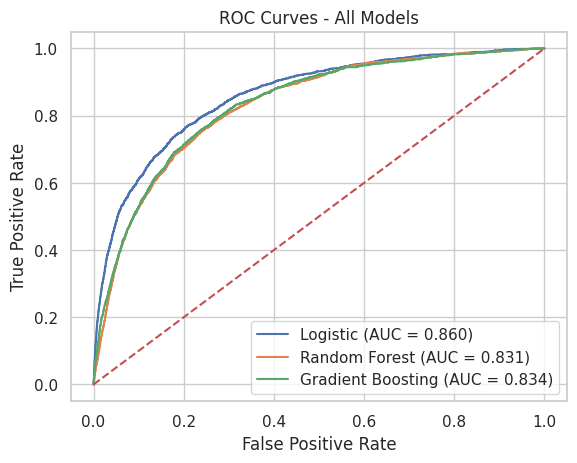

In [ ]:
gb_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('clf', GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

gb_pipeline.fit(X_train, y_train)

y_val_pred_gb = gb_pipeline.predict(X_val)
y_val_proba_gb = gb_pipeline.predict_proba(X_val)[:, 1]

gb_acc = accuracy_score(y_val, y_val_pred_gb)
gb_auc = roc_auc_score(y_val, y_val_proba_gb)

print("Gradient Boosting")
print("Accuracy:", gb_acc)
print("AUC:", gb_auc)

cm_gb = confusion_matrix(y_val, y_val_pred_gb)
tn, fp, fn, tp = cm_gb.ravel()
print("Confusion matrix:\n", cm_gb)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

print("\nClassification report:")
print(classification_report(y_val, y_val_pred_gb))

fpr_gb, tpr_gb, _ = roc_curve(y_val, y_val_proba_gb)

plt.figure()
plt.plot(fpr, tpr, label=f"Logistic (AUC = {baseline_auc:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_auc:.3f})")
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {gb_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - All Models")
plt.legend()
plt.show()


In [ ]:
# Check if test file contains labels
if 'SeriousDlqin2yrs' in test_df.columns and test_df['SeriousDlqin2yrs'].notna().sum() > 0:
    print("Test labels found. Calculating evaluation metrics...")

    y_test = test_df['SeriousDlqin2yrs']
    X_test = test_df.drop(columns=['SeriousDlqin2yrs'])

    best_pipeline = gb_pipeline

    y_test_pred = best_pipeline.predict(X_test)
    y_test_proba = best_pipeline.predict_proba(X_test)[:, 1]

    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Test AUC:", roc_auc_score(y_test, y_test_proba))

    cm_test = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm_test.ravel()
    print("Confusion Matrix:\n", cm_test)
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

else:
    print("No test labels present. Generating predictions only...")

    # FIX: Drop target column if it exists (even if all NaN)
    if 'SeriousDlqin2yrs' in test_df.columns:
        X_test = test_df.drop(columns=['SeriousDlqin2yrs'])
    else:
        X_test = test_df.copy()

    best_pipeline = gb_pipeline

    test_proba = best_pipeline.predict_proba(X_test)[:, 1]

    submission = pd.DataFrame({
        "Id": np.arange(1, len(test_proba) + 1),
        "ProbabilityOfDefault": test_proba
    })

    submission.to_csv("final_predictions.csv", index=False)
    print("Predictions saved as final_predictions.csv")
    submission.head()


No test labels present. Generating predictions only...
Predictions saved as final_predictions.csv
